<a href="https://colab.research.google.com/github/victorbahlangene/Fastai-part-2-2022/blob/main/14_augment_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmentation

In [ ]:
!pip install -Uqq git+https://github.com/fastai/course22p2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 12.4 MB/s eta 0:00:00


In [ ]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
fc.defaults.cpus

2

not applicable to my current cpu count

In [ ]:
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5

In [ ]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.824,0.704,0,train
0.855,0.576,0,eval
0.899,0.379,1,train
0.882,0.374,1,eval
0.922,0.265,2,train
0.909,0.283,2,eval


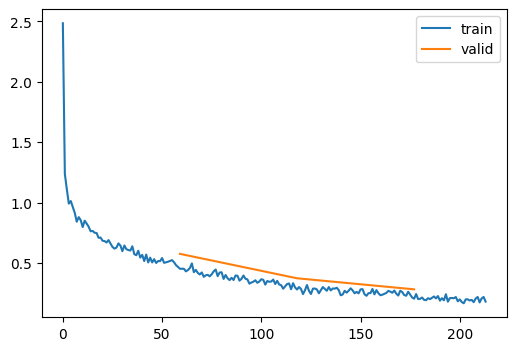

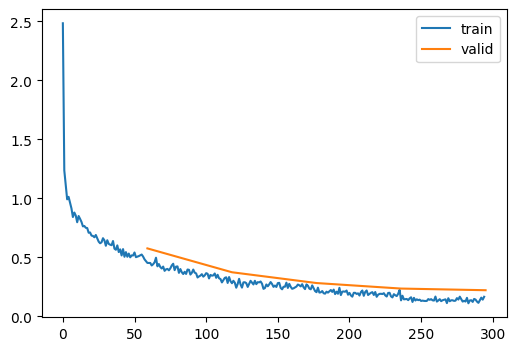

accuracy,loss,epoch,train
0.824,0.704,0,train
0.855,0.576,0,eval
0.899,0.379,1,train
0.882,0.374,1,eval
0.922,0.265,2,train
0.909,0.283,2,eval
0.941,0.197,3,train
0.927,0.236,3,eval
0.962,0.140,4,train
0.932,0.222,4,eval


In [15]:
learn.fit(epochs)

## Pooling

In [17]:
class GlobalAvgPool(nn.Module):
  def forward(self, x): return x.mean((-2,-1))

```python
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)
```

In [19]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
  layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
  layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
  layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
  layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
  return nn.Sequential(*layers)

In [20]:
get_model2()

Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (act): ReLU()
  )
  (1): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1

In [21]:
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [22]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.822,0.714,0,train
0.855,0.568,0,eval
0.899,0.382,1,train
0.882,0.391,1,eval
0.919,0.270,2,train
0.905,0.295,2,eval
0.940,0.201,3,train
0.923,0.245,3,eval
0.961,0.142,4,train
0.931,0.225,4,eval


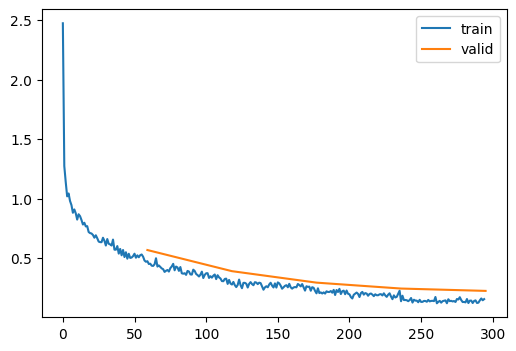

In [23]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [24]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
  layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
  layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
  layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
  return nn.Sequential(*layers)

In [25]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1231428; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [27]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

train results using **`get_model3`**

```python
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)
```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.810 | 0.758 |     0 | train |
|    0.857 | 0.489 |     0 | eval  |
|    0.893 | 0.402 |     1 | train |
|    0.890 | 0.350 |     1 | eval  |
|    0.917 | 0.282 |     2 | train |
|    0.913 | 0.283 |     2 | eval  |
|    0.937 | 0.212 |     3 | train |
|    0.922 | 0.260 |     3 | eval  |
|    0.957 | 0.158 |     4 | train |
|    0.930 | 0.230 |     4 | eval  |




In [28]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [31]:
get_model4()[0]

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [32]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [33]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


train with **`get_model4()`**.

```python
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)
```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.804 | 0.784 |     0 | train |
|    0.855 | 0.506 |     0 | eval  |
|    0.895 | 0.401 |     1 | train |
|    0.888 | 0.356 |     1 | eval  |
|    0.916 | 0.283 |     2 | train |
|    0.912 | 0.277 |     2 | eval  |
|    0.937 | 0.215 |     3 | train |
|    0.917 | 0.280 |     3 | eval  |
|    0.956 | 0.161 |     4 | train |
|    0.928 | 0.236 |     4 | eval  |



## Data augmentation

After 20 epochs without augmentation:

```
{'accuracy': '0.999', 'loss': '0.012', 'epoch': 19, 'train': True}
{'accuracy': '0.924', 'loss': '0.284', 'epoch': 19, 'train': False}
```
With batchnorm, weight decay doesn't really regularize.

In [34]:
from torchvision import transforms

Nb:
```python
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)
```

In [38]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [39]:
learn.fit(1)

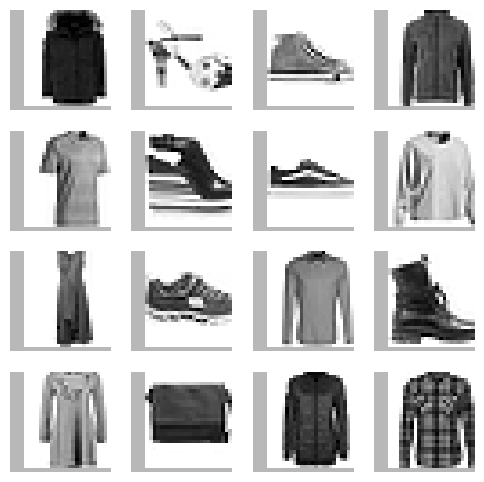

In [40]:
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [43]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

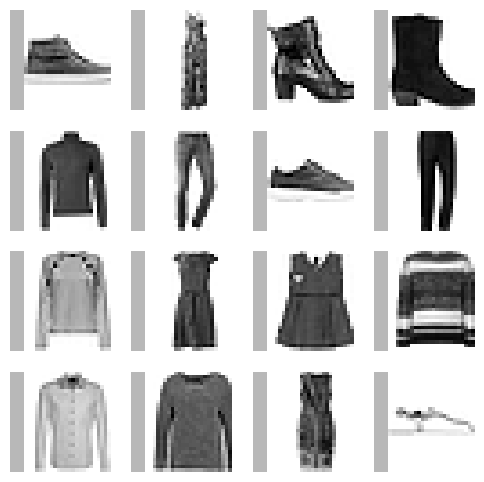

In [44]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [45]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

train:
```python
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)
```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.762 | 0.890 |     0 | train |
|    0.805 | 0.633 |     0 | eval  |
|    0.857 | 0.602 |     1 | train |
|    0.854 | 0.499 |     1 | eval  |
|    0.877 | 0.479 |     2 | train |
|    0.863 | 0.422 |     2 | eval  |
|    0.885 | 0.399 |     3 | train |
|    0.882 | 0.356 |     3 | eval  |
|    0.896 | 0.332 |     4 | train |
|    0.892 | 0.329 |     4 | eval  |
|    0.904 | 0.292 |     5 | train |
|    0.898 | 0.296 |     5 | eval  |
|    0.911 | 0.266 |     6 | train |
|    0.883 | 0.333 |     6 | eval  |
|    0.919 | 0.237 |     7 | train |
|    0.897 | 0.303 |     7 | eval  |
|    0.924 | 0.223 |     8 | train |
|    0.877 | 0.329 |     8 | eval  |
|    0.930 | 0.204 |     9 | train |
|    0.912 | 0.254 |     9 | eval  |
|    0.936 | 0.188 |    10 | train |
|    0.910 | 0.266 |    10 | eval  |
|    0.937 | 0.182 |    11 | train |
|    0.926 | 0.216 |    11 | eval  |
|    0.942 | 0.165 |    12 | train |
|    0.928 | 0.200 |    12 | eval  |
|    0.949 | 0.149 |    13 | train |
|    0.923 | 0.218 |    13 | eval  |
|    0.954 | 0.136 |    14 | train |
|    0.935 | 0.195 |    14 | eval  |
|    0.956 | 0.126 |    15 | train |
|    0.937 | 0.183 |    15 | eval  |
|    0.962 | 0.111 |    16 | train |
|    0.939 | 0.180 |    16 | eval  |
|    0.966 | 0.103 |    17 | train |
|    0.940 | 0.185 |    17 | eval  |
|    0.969 | 0.093 |    18 | train |
|    0.942 | 0.177 |    18 | eval  |
|    0.972 | 0.089 |    19 | train |
|    0.943 | 0.173 |    19 | eval  |



In [50]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.764,0.878,0,train
0.825,0.600,0,eval
0.859,0.596,1,train
0.871,0.484,1,eval
0.877,0.475,2,train
0.834,0.511,2,eval
0.888,0.389,3,train
0.881,0.352,3,eval
0.895,0.337,4,train
0.880,0.392,4,eval


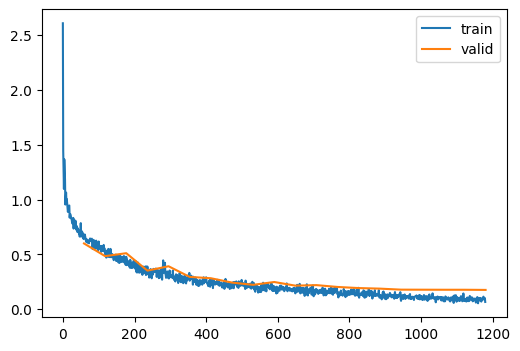

In [51]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations.

In [53]:
# saving models, since they are getting bigger and longer to train (36mins to train) #
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

## Test time augmentation (TTA)

In [62]:
learn.batch[0].shape, learn.batch[1].shape

(torch.Size([1808, 1, 28, 28]), torch.Size([1808]))

In [58]:
learn.preds.argmax(1)

tensor([9, 6, 3,  ..., 8, 1, 5], device='cuda:0')

In [63]:
class CapturePreds(Callback):
  def before_fit(self, learn): self.all_inps, self.all_preds, self.all_targs = [], [], []
  def after_batch(self, learn):
    self.all_inps. append(to_cpu(learn.batch[0]))
    self.all_preds.append(to_cpu(learn.preds))
    self.all_targs.append(to_cpu(learn.batch[1]))
  def after_fit(self, learn):
    self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

In [66]:
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

accuracy,loss,epoch,train
0.942,0.176,0,eval


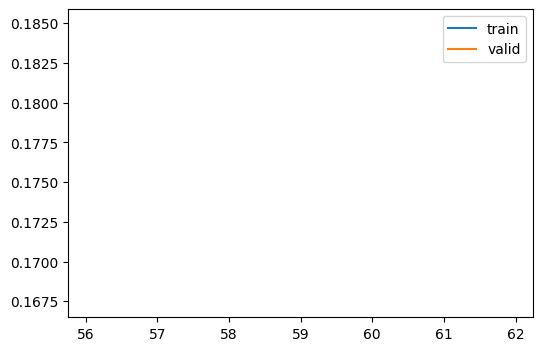

In [67]:
ap1, at = learn.capture_preds()

In [70]:
# preds, actuals #
ap1.shape, at

(torch.Size([10000, 10]), tensor([9, 2, 1,  ..., 8, 1, 5]))

accuracy,loss,epoch,train
0.943,0.175,0,eval


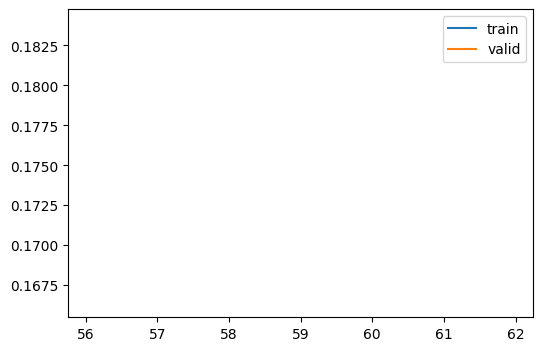

In [71]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [72]:
ap1.shape,ap2.shape,at.shape

(torch.Size([10000, 10]), torch.Size([10000, 10]), torch.Size([10000]))

In [73]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [74]:
ap.shape

torch.Size([10000])

In [77]:
round((ap==at).float().mean().item(), 3)

0.945

0.943 -> **0.945**

## Random erase

In [94]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [95]:
xbt.shape

torch.Size([16, 1, 28, 28])

In [96]:
xm,xs = xbt.mean(),xbt.std()

In [97]:
xbt.min(), xbt.max()

(tensor(-0.80), tensor(2.06))

In [98]:
pct = 0.2

In [99]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx,sty,szx,szy

(6, 4, 5, 5)

In [100]:
init.normal_(xbt[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs);

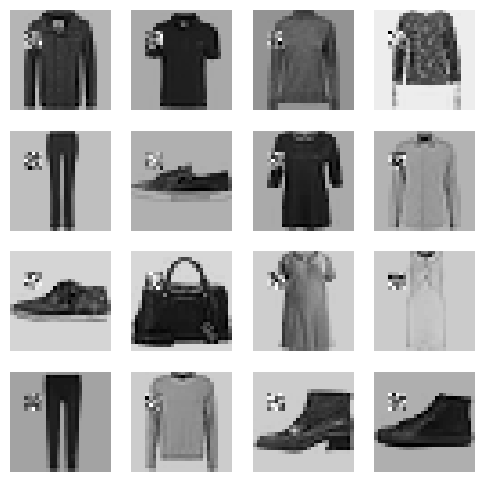

In [101]:
show_images(xbt, imsize=1.5)

In [102]:
xbt.min(), xbt.max()

(tensor(-3.20), tensor(2.52))

In [103]:
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

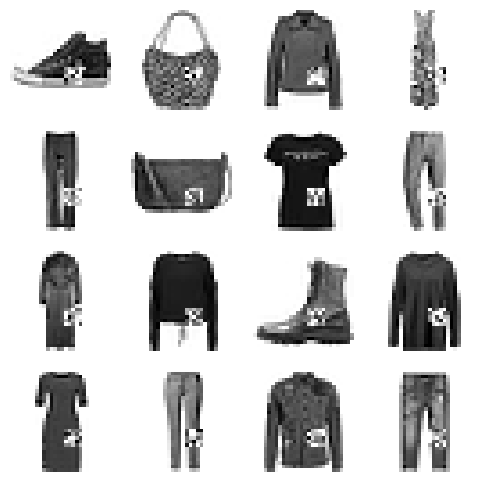

In [104]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [105]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

(tensor(0.03), tensor(1.01), tensor(-0.80), tensor(2.06))

In [106]:
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

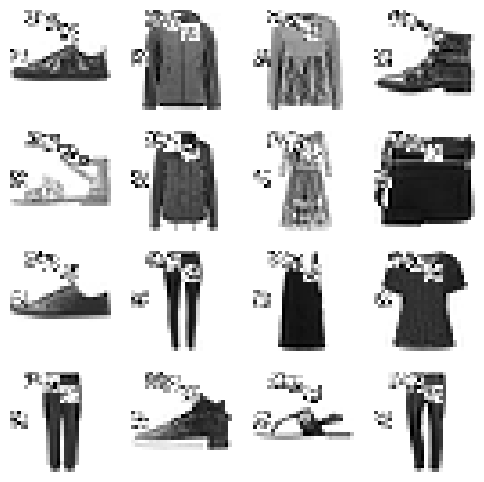

In [108]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [109]:
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [110]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

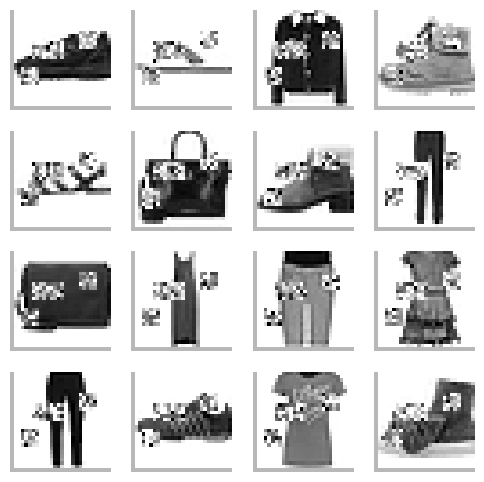

In [111]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

```python
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)
```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.764 | 0.875 |     0 | train |
|    0.813 | 0.622 |     0 | eval  |
|    0.842 | 0.625 |     1 | train |
|    0.850 | 0.552 |     1 | eval  |
|    0.861 | 0.537 |     2 | train |
|    0.864 | 0.446 |     2 | eval  |
.
|----------|-------|-------|-------|
|    0.976 | 0.068 |    48 | train |
|    0.949 | 0.162 |    48 | eval  |
|    0.976 | 0.070 |    49 | train |
|    0.949 | 0.163 |    49 | eval  |

## Random copy

In [112]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [113]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

(4, 17, 2, 8, 5, 5)

In [114]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

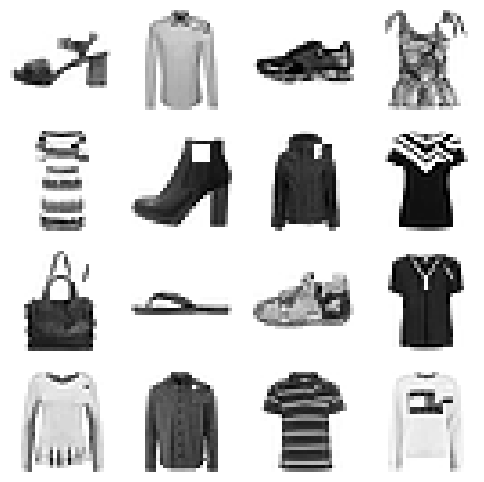

In [115]:
show_images(xbt, imsize=1.5)

In [116]:
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

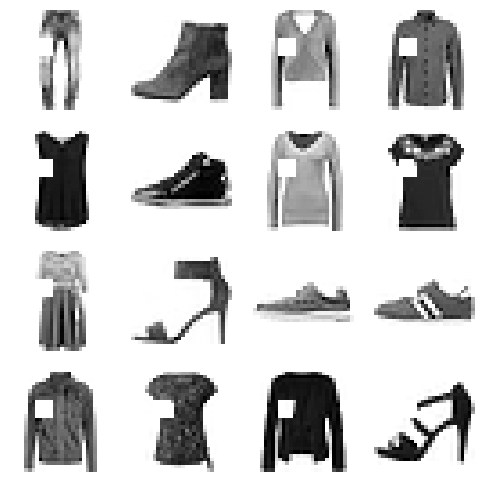

In [117]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)


In [118]:
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

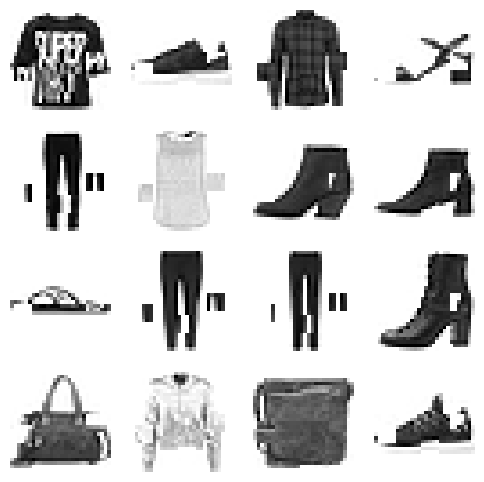

In [119]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [120]:
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

In [121]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

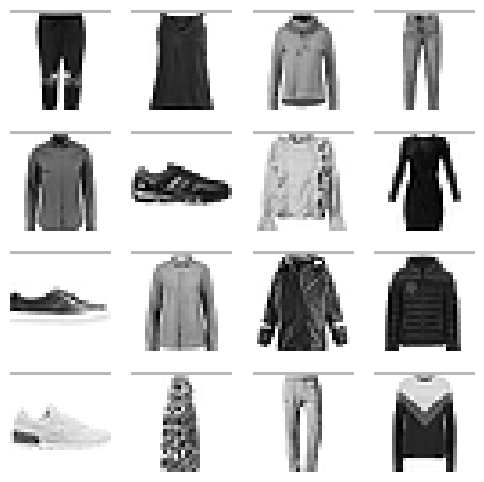

In [122]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

```python
set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.953 | 0.134 |    22 | train |
|    0.943 | 0.167 |    22 | eval  |
|    0.953 | 0.132 |    23 | train |
|    0.945 | 0.164 |    23 | eval  |
|    0.954 | 0.132 |    24 | train |
|    0.944 | 0.163 |    24 | eval  |



```python
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.952 | 0.138 |    22 | train |
|    0.941 | 0.171 |    22 | eval  |
|    0.954 | 0.134 |    23 | train |
|    0.942 | 0.169 |    23 | eval  |
|    0.954 | 0.131 |    24 | train |
|    0.944 | 0.166 |    24 | eval  |



```python
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')
     
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)
```
| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.944 | 0.163 |     0 | eval  |

```python
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)
```
| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.944 | 0.166 |     0 | eval  |

```python
ap = torch.stack([cp1.all_preds,cp2.all_preds]).mean(0).argmax(1)

round((ap==cp1.all_targs).float().mean().item(), 3)
```
0.947

## Dropout

In [124]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

In [125]:
class Dropout(nn.Module):
  def __init__(self, p=0.1):
    super().__init__()
    self.p = p

  def forward(self, x):
    if not self.training: return x
    dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
    return x * dist.sample(x.size()) * 1/(1-self.p)

In [126]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [127]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

```python
learn.fit(epochs)
```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
| 0.809    | 0.746 | 0     | train |
| 0.829    | 0.557 | 0     | eval  |
| 0.892    | 0.396 | 1     | train |
| 0.882    | 0.350 | 1     | eval  |
| 0.916    | 0.280 | 2     | train |
| 0.911    | 0.284 | 2     | eval  |
| 0.937    | 0.209 | 3     | train |
| 0.924    | 0.242 | 3     | eval  |
| 0.956    | 0.157 | 4     | train |
| 0.932    | 0.223 | 4     | eval  |



In [128]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout,nn.Dropout2d)) else None)

## Augment 2

```python
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)*2-1) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs
```

| accuracy | loss  | epoch | train |
|----------|-------|-------|-------|
|    0.965 | 0.104 |    17 | train |
|    0.939 | 0.185 |    17 | eval  |
|    0.968 | 0.096 |    18 | train |
|    0.941 | 0.180 |    18 | eval  |
|    0.971 | 0.091 |    19 | train |
|    0.941 | 0.177 |    19 | eval  |
|    0.916 | 0.280 |     2 | train |
|    0.911 | 0.284 |     2 | eval  |
|    0.937 | 0.209 |     3 | train |
|    0.924 | 0.242 |     3 | eval  |
|    0.956 | 0.157 |     4 | train |
|    0.932 | 0.223 |     4 | eval  |

